In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [2]:
import numpy as np
import pandas as pd
from time import time
from Node import Node

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Engine

In [21]:
class Engine:
    def __init__(self,opset,X,Y,log_odds,p,learning_rate,bins):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y

        self.log_odds = log_odds
        self.p = p
        self.residual = Y - p
        self.learning_rate = learning_rate
        self.bins = bins
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    def calculate_grad(self,val):
        bins = self.bins
        val_max = np.max(val)
        val_min = np.min(val)
        width = ((val_max - val_min)/bins)

        index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)

        residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
        p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)])
        grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

        grads = np.zeros(self.log_odds.shape)
        for i in range(bins):
            grads[index==i] = grad_bin[i]
            
        return grads
    
    def calculate_fitness(self,vals,beta):
        fitness = []
        for val in vals:
            grads = self.calculate_grad(val)
            log_odds_1 = self.log_odds + self.learning_rate * grads
                
            p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
            p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
            # loss = np.sum(np.power(self.Y - p_1,2))
            # loss = -np.sum(np.power(self.p - p_1,2))
            loss = -np.sum(np.abs(grads))
            
            fitness.append(loss)

        return fitness
    
    def calculate_decision(self,vals):
        for val in vals:
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(val,y_train)
            
            bins = len(clf.tree_.threshold)
            index = clf.apply(vals)
            
            residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(bins)])
            p_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(bins)])
            grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

            loss = -np.sum(clf.tree_.n_node_samples@np.abs(grad_bin))

        return loss

    def evolve(self,total_size,batch_size,elite_size,beta,verbose):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness = self.calculate_fitness(vals,beta)
            # fitness = self.calculate_decision(vals)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index] 
            )
            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

In [23]:
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    p_1 = np.exp(log_odds_1)
    p_1 = p_1/(1+p_1)

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,stack):
    log_odds = np.array([init_log_odds for i in range(X.shape[0])])
    p = np.array([init_p for i in range(X.shape[0])])

    for param in stack:
        node,node_param,grad_bin,learning_rate = param
        
        vals = node.predict(X)
        (table,width,val_max,val_min,bins) = node_param

        index = ((vals - val_min)//width).astype('int32')
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)
        
        grads = np.zeros(index.shape[0])
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# Stack

In [24]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [25]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p

def gradient(eg,log_odds,p,residual):
    val = eg.vals[eg.best[1].index]
    bins = eg.bins
    val_max = np.max(val)
    val_min = np.min(val)
    width = ((val_max - val_min)/bins)

    index = ((val - val_min)//width).astype('int32')
    index = np.where(index >= bins,bins-1,index)
    index = np.where(index < 0,0,index)

    residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(bins)])
    p_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(bins)])
    grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    grads = np.zeros(log_odds.shape)
    for i in range(bins):
        grads[index==i] = grad_bin[i]
        
    return grads,eg.best[1],(val_max,val_min,width,bins),grad_bin

def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for param in stack:
        node,node_param,grad_bin = param
        
        vals = node.predict(X)
        (val_max,val_min,width,bins) = node_param

        index = ((vals - val_min)//width).astype('int32')
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)
        
        grads = np.zeros(log_odds.shape)
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# data

In [63]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[1]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Higgs

In [26]:
df = pd.read_csv('../data/HIGGS.csv',header=None)
data_X = df.iloc[:,1:].to_numpy()
data_y = df.iloc[:,0].to_numpy().astype('int')

KeyboardInterrupt: 

In [10]:
X_train,X_test2,y_train,y_test2 = train_test_split(data_X,data_y,test_size=500000)
Xs,ys = shuffle(X_train,y_train)

In [11]:
i = 105000
j = 10500

X_train = Xs[:i]
y_train = ys[:i]

X_test = Xs[i:i+j]
y_test = ys[i:i+j]

# model

In [79]:
train_acc = []
test_acc = []

stack = []
learning_rate = 0.5
bins = 2

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

for g in range(1000):
    #regularization

    start = time()
    
    residual = y_train_one_hot - p
    
    eg = Engine(Functions.simple_opset,X_train,y_train_one_hot,log_odds,p,learning_rate,bins)
    for j in range(5):
            eg.evolve(100,100,30,[0,0,0],0)
        
    grads,node,node_param,grad_bin = gradient(eg,log_odds,p,residual)


    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    
    loss = np.sum(np.power(residual,2))
    
    running_time = time() - start
    if not np.isnan(loss):      
        stack.append((node,node_param,grad_bin))
        

        # test data prediction

        test_residual = y_test_one_hot - test_p
        test_loss = np.sum(np.power(test_residual,2))
        vals = node.predict(X_test)
        (val_max,val_min,width,bins) = node_param

        index = ((vals - val_min)//width).astype('int32')
        index = np.where(index >= bins,bins-1,index)
        index = np.where(index < 0,0,index)
        
        grads = np.zeros(test_log_odds.shape)
        for i in range(bins):
            grads[index==i] = grad_bin[i]
        
        test_log_odds,test_p = update_log_p(grads,test_log_odds,test_p,learning_rate)

        # train_acc.append(loss)
        # test_acc.append(test_loss)

        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(y_test,pred))
        
        # pred = p[:,1]
        # train_acc.append(roc_auc_score(y_train,pred))
        # pred = test_p[:,1]
        # test_acc.append(roc_auc_score(y_test,pred))
    
        print("Generation:",g,loss,test_loss,train_acc[-1],test_acc[-1],str(round(running_time,3))+'s')
    else:
        break

-401.6604600300058 -400.72953765104717
-400.72953765104717 -400.72953765104717
-410.9494002644426 -400.72953765104717
-400.72953765104717 -400.72953765104717
-478.4341580275735 -410.63909280478964


TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

In [4]:
pred = predict(X_test,init_log_odds,init_p,learning_rate,stack[:512])
# pred = np.argmax(pred,axis=1)
# print(classification_report(y_test,pred))

pred = pred[:,1]
print(roc_auc_score(y_test,pred))

NameError: name 'predict' is not defined

In [5]:
pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
# print(classification_report(y_train,pred))
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
# pred = np.argmax(pred,axis=1)
# print(classification_report(y_test,pred))

pred = pred[:,1]
print(roc_auc_score(y_test,pred))

NameError: name 'predict' is not defined

In [6]:
from sklearn.preprocessing import minmax_scale
i = 200
acc = np.array(train_acc)

# w = [np.sum(np.abs(grad_bin)) for node,node_param,grad_bin in stack[:i]]
w = [np.sum(grad_bin) for node,node_param,grad_bin in stack[:i]]

# w = minmax_scale(w)
# m = minmax_scale(acc[1:i+1]-acc[:i])
m = acc[:i]
plt.plot(w)
plt.show()
plt.plot(m[1:]-m[:-1])
plt.show()

NameError: name 'train_acc' is not defined

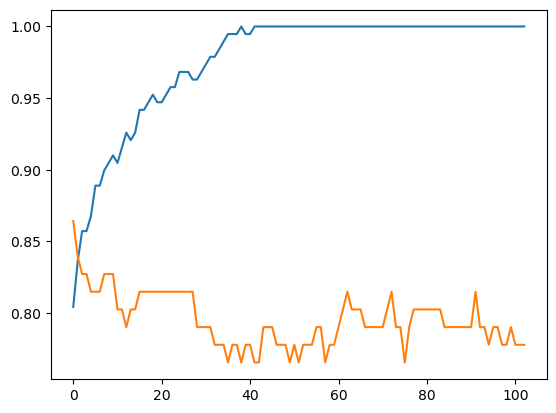

In [57]:
plt.plot(train_acc)
plt.plot(test_acc)

In [21]:
import xgboost

In [22]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

pred = xgb.predict_proba(X_train)
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=3))

pred = xgb.predict_proba(X_test)
pred = pred[:,1]
print(roc_auc_score(y_test,pred))

              precision    recall  f1-score   support

           0      0.791     0.768     0.779     49174
           1      0.801     0.821     0.811     55826

    accuracy                          0.796    105000
   macro avg      0.796     0.795     0.795    105000
weighted avg      0.796     0.796     0.796    105000

0.8790478829199369
              precision    recall  f1-score   support

           0      0.723     0.703     0.713      4967
           1      0.740     0.758     0.749      5533

    accuracy                          0.732     10500
   macro avg      0.731     0.730     0.731     10500
weighted avg      0.732     0.732     0.732     10500

0.8064684717800051


In [35]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
clf = GradientBoostingClassifier(n_estimators=300).fit(X_train, y_train)

In [37]:
pred = clf.predict_proba(X_train)
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

1.0


In [38]:
pred = clf.predict_proba(X_test)
pred = pred[:,1]
print(roc_auc_score(y_test,pred))

0.8821733821733821


In [39]:
pred = clf.predict(X_test)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

           0      0.804     0.881     0.841        42
           1      0.857     0.769     0.811        39

    accuracy                          0.827        81
   macro avg      0.831     0.825     0.826        81
weighted avg      0.830     0.827     0.826        81



In [40]:
w = [0]

for e in clf.estimators_:
    a = e[0]
    w.append(w[-1] + np.sum(a.tree_.value))

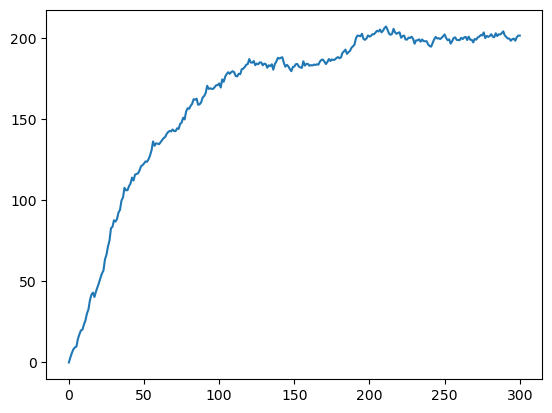

In [41]:
plt.plot(w)

In [6]:
df = pd.read_csv("../data/sleep.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")
y[y==5] = 4

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
X = np.array([
    [0,1],[0,1.5],[0,2],[1,0],[1.5,0],[2,0]
])
y = np.array(['a','b','a','b','a','b'])

In [7]:
clf = DecisionTreeClassifier(max_depth=1,criterion='gini')
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=1)

In [8]:
clf.tree_.impurity

array([0.68120889, 0.52511201, 0.62617254])

In [9]:
index_leaves = clf.tree_.threshold == -2
impurity = clf.tree_.impurity[index_leaves]
n_nodes_samples = clf.tree_.n_node_samples[index_leaves]
impurity@(n_nodes_samples/sum(n_nodes_samples))

0.6091639404809513

In [10]:
bin_index = clf.apply(X_train)

In [11]:
df = pd.crosstab(bin_index,y_train)

In [13]:
bin_weight_by_class

col_0,0,1,2,3,4
row_0,,,,,
1,0.545382,0.325075,0.046113,0.001451,0.065775
2,0.454618,0.674925,0.953887,0.998549,0.934225


In [16]:
df

col_0,0,1,2,3,4
row_0,,,,,
1,8154,2060,1701,11,551
2,6797,4277,35187,7571,7826


In [15]:
impurity_by_class_bin.sum(axis=1)

col_0
0    0.439244
1    0.032071
2    0.344262
3    0.015078
4    0.018060
dtype: float64

In [12]:
bin_index = clf.apply(X_train)
df = pd.crosstab(bin_index,y_train)

bin_weight_by_class = (df/df.sum(axis=0))
impurity_by_class_bin = ((df.T/df.sum(axis=1))**2)
gains_by_class = (bin_weight_by_class.T*impurity_by_class_bin).sum(axis=1)
gains_by_class.values

array([0.23845253, 0.01210885, 0.3115152 , 0.01505557, 0.01517882])

In [23]:
(bin_prob*(df.T/df.sum(axis=1))**2).sum(axis=1)

col_0
0    0.082748
1    0.008560
2    0.274254
3    0.012560
4    0.013753
dtype: float64

In [102]:
((df.T/df.sum(axis=1))).sum(axis=1)

col_0
0    0.764191
1    0.233040
2    0.707883
3    0.123985
4    0.170900
dtype: float64